In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import random
import tqdm
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, UpSampling2D
from tensorflow.keras.applications import densenet

In [2]:
path = "DATA"
img_path = "1812.png"

In [3]:
def degrade_image(img: np.ndarray) -> np.ndarray:
    """
    Функция искусственно ухудшает изображение, чтобы имитировать реальные
    проблемы качества фотографий. Используется для создания входных данных
    (плохое качество), тогда как оригинальное изображение остаётся эталоном
    (хорошее качество).

    Случайным образом применяются следующие ухудшения:
    - JPEG-сжатие с потерей качества (артефакты компрессии)
    - Гауссово размытие (нефокус, слабое размытие)
    - Добавление гауссовского шума (шум матрицы камеры)
    - Изменение яркости и контраста (плохое освещение)
    - Смаз по направлению движения (motion blur)

    Все преобразования сохраняют:
    - исходный размер изображения
    - формат uint8
    - диапазон значений пикселей [0, 255]

    Эта функция НЕ является preprocess’ом для нейросети.
    Она используется только для генерации ухудшенных изображений
    в датасете (data degradation).

    Args:
        img (np.ndarray): Входное изображение в формате BGR
                          размером (H, W, 3), тип uint8.

    Returns:
        np.ndarray: Ухудшенное изображение того же размера и типа.
    """
    img = img.copy()

    # JPEG compression
    if random.random() < 0.8:
        quality = random.randint(50, 90)
        _, enc = cv2.imencode(
            '.jpg', img,
            [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        )
        img = cv2.imdecode(enc, cv2.IMREAD_COLOR)

    # Gaussian Blur 
    if random.random() < 0.5:
        k = random.choice([3, 5])
        sigma = random.uniform(0.3, 1.2)
        img = cv2.GaussianBlur(img, (k, k), sigma)

    # Gaussian Noise 
    if random.random() < 0.4:
        std = random.uniform(3, 10)
        noise = np.random.normal(0, std, img.shape).astype(np.float32)
        img = img.astype(np.float32) + noise
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Brightness / Contrast 
    if random.random() < 0.3:
        alpha = random.uniform(0.9, 1.1)  
        beta = random.randint(-10, 10)    
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Motion Blur
    if random.random() < 0.1:
        k = random.randint(5, 10)
        kernel = np.zeros((k, k))
        kernel[k // 2, :] = 1.0
        kernel /= kernel.sum()
        img = cv2.filter2D(img, -1, kernel)

    return img

In [4]:
def valid_patch(patch, min_size=16):
    patch = np.array(patch)
    if patch.ndim == 2:  
        h, w = patch.shape
        c = 1
    elif patch.ndim == 3:
        h, w, c = patch.shape
    else:
        return None  

    if h < min_size or w < min_size or c == 0:
        return None  

    return patch

In [5]:
def process_patch(patch: np.ndarray, target_size: int) -> np.ndarray:
    """
    Дополняет маленький патч нулями или ресайзит до target_size x target_size.
    """
    if patch.ndim != 3:
        raise ValueError(f"Patch must have 3 dimensions, got {patch.shape}")

    h, w = patch.shape[:2]

    pad_h = max(0, target_size - h)
    pad_w = max(0, target_size - w)

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    patch = np.pad(patch, ((top, bottom), (left, right), (0, 0)), mode='constant', constant_values=0)

    if patch.shape[0] != target_size or patch.shape[1] != target_size:
        patch = cv2.resize(patch, (target_size, target_size))

    return patch


In [6]:
def extract_patches(img: np.ndarray, patch_size: int = 224, step: int = 224):
    """
    Разбивает изображение на патчи с возможным покрытием краёв.
    """
    H, W = img.shape[:2]
    patches = []

    if H < patch_size or W < patch_size:
        return [img], H, W

    y_poss = np.arange(0, H - patch_size + 1, step).tolist()
    if y_poss[-1] + patch_size < H:
        y_poss.append(H - patch_size)

    x_poss = np.arange(0, W - patch_size + 1, step).tolist()
    if x_poss[-1] + patch_size < W:
        x_poss.append(W - patch_size)

    for y in y_poss:
        for x in x_poss:
            patches.append(img[y:y+patch_size, x:x+patch_size].copy())

    return patches, H, W

In [7]:
def merge_patches(patches, H, W, patch_size=224, step=224):

    C = patches[0].shape[2]
    output = np.zeros((H, W, C), dtype=np.float32)
    weight = np.zeros((H, W, C), dtype=np.float32)

    y_poss = list(range(0, H - patch_size + 1, step))
    if y_poss[-1] + patch_size < H:
        y_poss.append(H - patch_size)

    x_poss = list(range(0, W - patch_size + 1, step))
    if x_poss[-1] + patch_size < W:
        x_poss.append(W - patch_size)

    idx = 0
    for y in y_poss:
        for x in x_poss:
            output[y:y+patch_size, x:x+patch_size] += patches[idx]
            weight[y:y+patch_size, x:x+patch_size] += 1
            idx += 1

    output /= weight
    return output.astype(np.uint8)


In [8]:
def load_and_preprocess_images(path: str, patch_size: int = 224, step: int = 224):
    """
    Загружает изображения, ухудшает их и подготавливает данные для DenseNet + U-Net.
    """
    clean_patches = []
    degraded_patches = []

    for filename in tqdm.tqdm(os.listdir(path)):
        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        patches, H, W = extract_patches(img, patch_size, step)

        for patch in patches:
            patch = process_patch(patch, patch_size)

            clean = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB).astype(np.float32)
            degraded = degrade_image(patch)
            degraded = cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB).astype(np.float32)

            clean = densenet.preprocess_input(clean)
            degraded = densenet.preprocess_input(degraded)

            clean_patches.append(clean)
            degraded_patches.append(degraded)

    X = np.stack(degraded_patches, axis=0)
    Y = np.stack(clean_patches, axis=0)

    return X, Y

## Model Making

In [9]:
def regressor(x):
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    
    return x

In [10]:
def decoder(x):
    x = tf.keras.layers.UpSampling2D()(x)
    x1 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    x = tf.keras.layers.UpSampling2D()(x1)
    x2 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    x = tf.keras.layers.UpSampling2D()(x2)
    out = tf.keras.layers.Conv2D(3, 3, padding="same")(x)

    return out

In [11]:
def UNetDenseNetEnhancer(path, patch_size=224, regressor=regressor, decoder=decoder, H=224, W=224):
    """
    Создает и обучает модель U-Net с DenseNet encoder и кастомным регрессором + декодером.

    Args:
        path (str): путь к папке с изображениями
        epoches (int): количество эпох
        batch_size (int): размер батча
        patch_size (int): размер патча для извлечения
        regressor_fn (callable): функция, создающая регрессор
        decoder_fn (callable): функция, создающая декодер
        H, W (int): высота и ширина входного изображения
    """
    
    # Data
    X, Y = load_and_preprocess_images(path, patch_size=patch_size, step=patch_size)   
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    # Model
    inp = Input(shape=(patch_size, patch_size, 3))
    encoder = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_tensor=inp)
    for layer in encoder.layers:
        layer.trainable = False

    x = encoder.output  # (7,7,1920) if patch_size=224
    # Decoder (U-Net style)
    x = UpSampling2D(2)(x)  # 14x14
    x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)  # 28x28
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)  # 56x56
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)  # 112x112
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)  # 224x224
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    output = Conv2D(3, (1,1), activation='sigmoid', padding='same')(x)

    model = keras.Model(inputs=inp, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='mean_absolute_error',
                  metrics=['mae'])

    # # Fit
    # model.fit(x_train, y_train,
    #           validation_data=(x_test, y_test),
    #           epochs=epoches,
    #           batch_size=batch_size)

    return model, x_train, x_test, y_train, y_test

## Use Model

In [12]:
model, x_train, x_test, y_train, y_test = UNetDenseNetEnhancer(path, 10)

100%|██████████████████████████████████████████████████████████████████████████████| 6899/6899 [01:35<00:00, 72.40it/s]


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 28,737,155 (109.62 MB)

 Trainable params: 10,415,171 (39.73 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [16]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((13567, 224, 224, 3),
 (3392, 224, 224, 3),
 (13567, 224, 224, 3),
 (3392, 224, 224, 3))

In [17]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=10,
          batch_size=64)

Epoch 1/10
 81/212 ━━━━━━━━━━━━━━━━━━━━ 30:48 14s/step - loss: 1.1928 - mae: 1.1928

KeyboardInterrupt: 

## Examples

395 483


ValueError: num must be an integer with 1 <= num <= 4, not 5

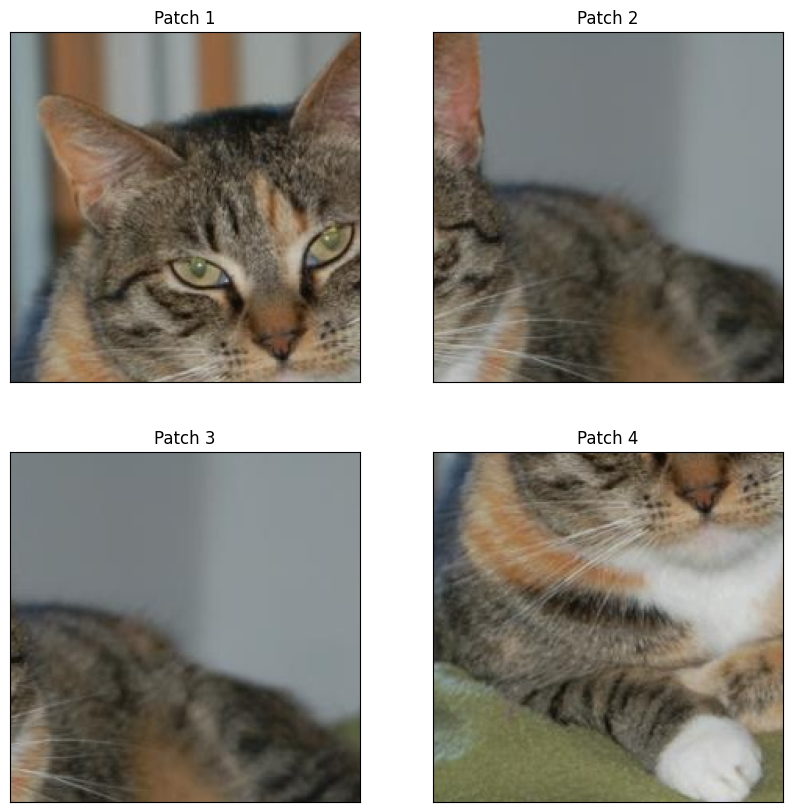

In [20]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
patches, H, W = extract_patches(img)
print(H, W)

plt.figure(figsize=(10, 10))
for i in range(len(patches)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(patches[i])
    plt.title(f"Patch {i+1}")
    plt.xticks([])
    plt.yticks([])

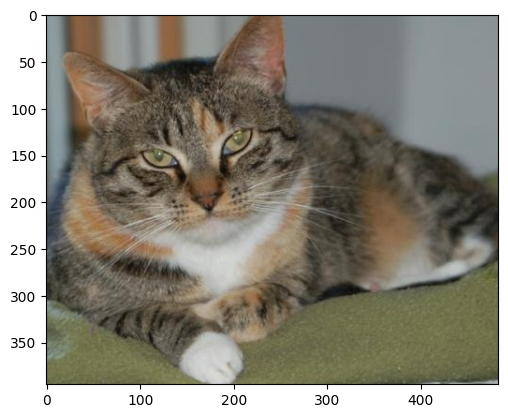

In [21]:
merged_img = merge_patches(patches, H, W)
plt.imshow(merged_img)

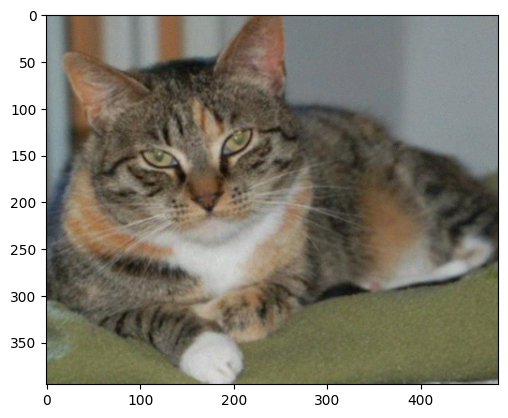

In [24]:
img_p = degrade_image(img)
plt.imshow(img_p)

In [65]:
data, y = load_and_preprocess_images(path)

100%|█████████████████████████████████████████████████████████████████████████████| 6899/6899 [00:24<00:00, 280.61it/s]


In [67]:
img_ex = data[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


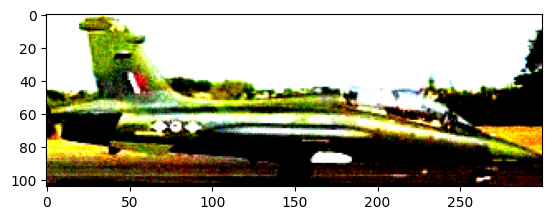

In [68]:
plt.imshow(img_ex)

In [25]:
img_p = 
model.predict(img_p)

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 483, 3)